## Best model notebook

### Group 8 Members
#### Spring Semester 2024-2025
- Alexandre Gonçalves - 20240738
- Bráulio Damba - 20240007
- Hugo Fonseca - 20240520
- Ricardo Pereira - 20240745
- Victoria Goon - 20240550

## 0 - Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
import re
import string
import nltk
from sklearn.metrics.pairwise import cosine_distances
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Text extraction 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_distances
from collections import Counter

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from gensim.models import FastText

import scipy.sparse
from scipy import sparse

import contractions
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import gensim.downloader as api

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

import pickle
from sklearn.utils import resample

from itertools import product

from sentence_transformers import SentenceTransformer

# Deep Learning libraries
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout, Flatten, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dropout, Flatten, GRU
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, AutoModel
import torch

# Set pd options to display all columns and rows
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 30)
pd.set_option('display.max_colwidth', None)  

import glob
from scipy.sparse import load_npz

from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, GRU, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.base import clone


from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from transformers import (
    BartTokenizer,
    BartForSequenceClassification,
    BartConfig,
)
import optuna

import json

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/ricardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ricardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ricardo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Import the encoded files

In [2]:
# Define the base directory (where the notebook is)
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))

# Construct full paths to the CSV files
train_path = os.path.join(BASE_DIR, "data", "train.csv")
test_path = os.path.join(BASE_DIR, "data", "test.csv")

# Load the datasets
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [3]:
folder = '.'  # Use '.' if running in the current directory, or the path to your folder

# List all .npy and .npz files
npy_files = glob.glob(os.path.join(folder, '*.npy'))
npz_files = glob.glob(os.path.join(folder, '*.npz'))

In [4]:
npy_embeddings = {}

for f in npy_files:
    name = os.path.splitext(os.path.basename(f))[0]
    npy_embeddings[name] = np.load(f, allow_pickle=True)

In [5]:
npz_embeddings = {}

for f in npz_files:
    name = os.path.splitext(os.path.basename(f))[0]
    try:
        npz_embeddings[name] = load_npz(f)
    except Exception as e:
        print(f"Warning: Failed to load '{f}' as a sparse matrix. Error: {e}")
        try:
            npz_embeddings[name] = np.load(f)
            print(f"Loaded '{f}' as dense array (np.load).")
        except Exception as e2:
            print(f"Failed to load '{f}' as dense array too. Skipping. Error: {e2}")


In [6]:
# Using stratify to maintain the distribution of classes in the train, validation, and test sets 
# As our dataset is quite small, we use 80% for training, and split the remaining 20% into validation and test sets (10% each).

train_df, val_test_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label'], random_state=42)

In [7]:
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

In [9]:
# Load from file
with open("best_bart_params.json", "r") as f:
    best_params = json.load(f)

print("Best parameters loaded:", best_params)

Best parameters loaded: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.1}


## 1 - Hyperparameter tuning BART

In [10]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base", use_fast=True)

# Dataset construction
train_df = Dataset.from_dict({
    "text_no_lemma_stem_with_stopwords": npy_embeddings["train_text_no_lemma_stem_with_stopwords"],
    "label": y_train.tolist()
})
val_df = Dataset.from_dict({
    "text_no_lemma_stem_with_stopwords": npy_embeddings["val_text_no_lemma_stem_with_stopwords"],
    "label": y_val.tolist()
})
test_df = Dataset.from_dict({
    "text_no_lemma_stem_with_stopwords": npy_embeddings["test_text_no_lemma_stem_with_stopwords"],
    "label": y_test.tolist()
})


Using device: mps


In [11]:
# Tokenization 
def tokenize_dataset(dataset):
    return dataset.map(
        lambda examples: tokenizer(
            examples["text_no_lemma_stem_with_stopwords"],
            padding="max_length",
            truncation=True,
            max_length=64
        ),
        batched=True
    )
    
# Metric for optimization
def compute_metrics(pred):
    try:
        logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
        preds = np.argmax(logits, axis=1)
        labels = pred.label_ids
        return {"macro_f1": f1_score(labels, preds, average="macro")}
    except Exception as e:
        print(f"Metric computation error: {e}")
        return {"macro_f1": 0.0}

In [ ]:
# Optuna search space
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [1e-5, 2e-5, 3e-5, 5e-5]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [3, 4, 5]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01]),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 100, 500]),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2]),
        "dropout": trial.suggest_categorical("dropout", [0.1, 0.2]),
    }

# Model init
def model_init(trial):
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2])
    config = BartConfig.from_pretrained("facebook/bart-base", num_labels=3, attention_dropout=dropout, dropout=dropout)
    return BartForSequenceClassification.from_pretrained("facebook/bart-base", config=config)

# TrainingArguments
def build_training_args(trial):
    return TrainingArguments(
        output_dir="./results_bart_tune",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=trial.suggest_categorical("learning_rate", [1e-5, 2e-5, 3e-5, 5e-5]),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        num_train_epochs=trial.suggest_categorical("num_train_epochs", [3, 4, 5]),
        weight_decay=trial.suggest_categorical("weight_decay", [0.0, 0.01]),
        warmup_steps=trial.suggest_categorical("warmup_steps", [0, 100, 500]),
        gradient_accumulation_steps=trial.suggest_categorical("gradient_accumulation_steps", [1, 2]),
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        report_to="none"
    )

def objective(trial):
    train_dataset = tokenize_dataset(train_df).rename_column("label", "labels")
    val_dataset = tokenize_dataset(val_df).rename_column("label", "labels")

    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    trainer = Trainer(
        model_init=lambda: model_init(trial),
        args=build_training_args(trial),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_macro_f1"]

In [10]:
# Run Optuna search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Display best hyperparameters
print("Best hyperparameters found:")
print(study.best_params)

[I 2025-06-14 00:51:36,250] A new study created in memory with name: no-name-9be3e78d-57c4-4b58-b786-561890b1ac5a
Map: 100%|██████████| 954/954 [00:00<00:00, 11663.17 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'class

Epoch,Training Loss,Validation Loss,Macro F1
1,0.638800,0.460890,0.787788
2,0.462700,0.441597,0.818824
3,0.392400,0.429596,0.825238
4,0.334500,0.432973,0.830969


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:02:23,916] Trial 0 finished with value: 0.8309686677181131 and parameters: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 0 with value: 0.8309686677181131.
Map: 100%|██████████| 954/954 [00:00<00:00, 11654.88 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.841800,0.604960,0.748586
2,0.625000,0.478839,0.768831
3,0.568300,0.456748,0.786488


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:08:02,000] Trial 1 finished with value: 0.7864876891056505 and parameters: {'learning_rate': 1e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.8309686677181131.
Map: 100%|██████████| 954/954 [00:00<00:00, 11233.04 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Epoch,Training Loss,Validation Loss,Macro F1
1,0.707600,0.501660,0.768498
2,0.512100,0.525204,0.794742
3,0.422600,0.503320,0.808938


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:16:04,675] Trial 2 finished with value: 0.8089379880363371 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 1, 'dropout': 0.2}. Best is trial 0 with value: 0.8309686677181131.
Map: 100%|██████████| 954/954 [00:00<00:00, 11320.24 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.703800,0.463265,0.780278
2,0.472600,0.422532,0.811223
3,0.301900,0.380167,0.836306


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:22:45,745] Trial 3 finished with value: 0.8363058639654385 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.0, 'warmup_steps': 500, 'gradient_accumulation_steps': 2, 'dropout': 0.1}. Best is trial 3 with value: 0.8363058639654385.
Map: 100%|██████████| 954/954 [00:00<00:00, 11711.27 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Epoch,Training Loss,Validation Loss,Macro F1
1,0.638800,0.460891,0.787788
2,0.462700,0.441598,0.818824
3,0.392400,0.429640,0.825238
4,0.334500,0.432878,0.828969


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:33:27,956] Trial 4 finished with value: 0.8289689473624101 and parameters: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 3 with value: 0.8363058639654385.
Map: 100%|██████████| 954/954 [00:00<00:00, 11650.51 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.693000,0.458175,0.775632
2,0.520700,0.515046,0.790318
3,0.432500,0.416983,0.820058
4,0.380000,0.414531,0.816970


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:41:47,065] Trial 5 finished with value: 0.8200583693947268 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.2}. Best is trial 3 with value: 0.8363058639654385.
Map: 100%|██████████| 954/954 [00:00<00:00, 11502.11 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Epoch,Training Loss,Validation Loss,Macro F1
1,0.706200,0.487944,0.771932
2,0.503200,0.524727,0.795593
3,0.390500,0.451313,0.810678


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:48:30,523] Trial 6 finished with value: 0.8106780662970721 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 2, 'dropout': 0.2}. Best is trial 3 with value: 0.8363058639654385.
Map: 100%|██████████| 954/954 [00:00<00:00, 11226.96 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.733200,0.466438,0.775077
2,0.491400,0.402788,0.830141
3,0.355500,0.373111,0.841026
4,0.276400,0.389027,0.836698


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 01:56:48,380] Trial 7 finished with value: 0.8410262724963858 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_steps': 500, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 7 with value: 0.8410262724963858.
Map: 100%|██████████| 954/954 [00:00<00:00, 11502.61 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Epoch,Training Loss,Validation Loss,Macro F1
1,0.630400,0.440314,0.791306
2,0.402500,0.423279,0.815952
3,0.267300,0.441139,0.824498
4,0.189100,0.519605,0.833499


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 02:05:05,709] Trial 8 finished with value: 0.8334989994313995 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 7 with value: 0.8410262724963858.
Map: 100%|██████████| 954/954 [00:00<00:00, 11642.54 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Epoch,Training Loss,Validation Loss,Macro F1
1,0.640300,0.443667,0.788231
2,0.431800,0.404021,0.818580
3,0.329000,0.381881,0.835817
4,0.258100,0.398963,0.835808


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 02:14:02,497] Trial 9 finished with value: 0.8358174806741087 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_steps': 100, 'gradient_accumulation_steps': 2, 'dropout': 0.1}. Best is trial 7 with value: 0.8410262724963858.
Map: 100%|██████████| 954/954 [00:00<00:00, 11326.81 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.733200,0.466350,0.777262
2,0.494000,0.397394,0.825229
3,0.357800,0.374417,0.845337
4,0.278000,0.431926,0.833636
5,0.220800,0.424164,0.843684


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 02:24:03,106] Trial 10 finished with value: 0.845336916582828 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 500, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 10 with value: 0.845336916582828.
Map: 100%|██████████| 954/954 [00:00<00:00, 11618.27 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.733200,0.466350,0.777262
2,0.493900,0.397678,0.830349
3,0.358200,0.377443,0.842340
4,0.277700,0.439039,0.832428
5,0.222100,0.424668,0.838477


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 02:34:04,840] Trial 11 finished with value: 0.8423397640276044 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 500, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 10 with value: 0.845336916582828.
Map: 100%|██████████| 954/954 [00:00<00:00, 11657.74 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Epoch,Training Loss,Validation Loss,Macro F1
1,0.733200,0.466348,0.777262
2,0.494100,0.397555,0.829625
3,0.357300,0.373614,0.846039
4,0.279300,0.437355,0.831194
5,0.221700,0.422925,0.842644


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 02:44:10,234] Trial 12 finished with value: 0.8460390703674294 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 500, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 12 with value: 0.8460390703674294.
Map: 100%|██████████| 954/954 [00:00<00:00, 11572.07 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predic

Epoch,Training Loss,Validation Loss,Macro F1
1,0.733200,0.466352,0.777262
2,0.493900,0.397537,0.826481
3,0.356400,0.377076,0.845246
4,0.278300,0.435076,0.834183
5,0.221000,0.421978,0.839911


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 02:54:14,656] Trial 13 finished with value: 0.8452461291325379 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 500, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 12 with value: 0.8460390703674294.
Map: 100%|██████████| 954/954 [00:00<00:00, 11691.87 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predic

Epoch,Training Loss,Validation Loss,Macro F1
1,0.733200,0.466363,0.777262
2,0.494100,0.395911,0.825790
3,0.357400,0.375841,0.848531
4,0.278100,0.435420,0.839134
5,0.221400,0.422327,0.843383


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 03:04:20,745] Trial 14 finished with value: 0.8485314473052892 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 500, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 14 with value: 0.8485314473052892.
Map: 100%|██████████| 954/954 [00:00<00:00, 11673.55 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predic

Epoch,Training Loss,Validation Loss,Macro F1
1,0.602400,0.444756,0.795174
2,0.418200,0.439587,0.819462
3,0.329800,0.397937,0.837045
4,0.265200,0.427904,0.836327
5,0.215000,0.414799,0.849389


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 03:14:25,330] Trial 15 finished with value: 0.8493888441221237 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 15 with value: 0.8493888441221237.
Map: 100%|██████████| 954/954 [00:00<00:00, 11444.47 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.602400,0.444751,0.795174
2,0.418200,0.439539,0.819462
3,0.329800,0.397917,0.837045
4,0.265200,0.427974,0.835001
5,0.215000,0.414612,0.849389


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 03:24:28,807] Trial 16 finished with value: 0.8493888441221237 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 15 with value: 0.8493888441221237.
Map: 100%|██████████| 954/954 [00:00<00:00, 11670.86 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.602400,0.444767,0.795174
2,0.418200,0.439764,0.819462
3,0.329800,0.398267,0.835877
4,0.265200,0.428271,0.835170
5,0.215000,0.414892,0.849389


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 03:34:30,796] Trial 17 finished with value: 0.8493888441221237 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 15 with value: 0.8493888441221237.
Map: 100%|██████████| 954/954 [00:00<00:00, 11372.04 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.717100,0.485494,0.762149
2,0.531700,0.548557,0.763370
3,0.435400,0.453943,0.806307
4,0.376700,0.461829,0.823120
5,0.325000,0.434850,0.828782


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 03:43:36,200] Trial 18 finished with value: 0.8287824741103872 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 2, 'dropout': 0.2}. Best is trial 15 with value: 0.8493888441221237.
Map: 100%|██████████| 954/954 [00:00<00:00, 11627.89 examples/s]
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/4189195025.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch,Training Loss,Validation Loss,Macro F1
1,0.602400,0.444764,0.795174
2,0.418200,0.439712,0.819462
3,0.329900,0.397680,0.837045
4,0.265200,0.428252,0.836739
5,0.215000,0.415244,0.849389


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

[I 2025-06-14 03:53:41,704] Trial 19 finished with value: 0.8493888441221237 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.1}. Best is trial 15 with value: 0.8493888441221237.


Best hyperparameters found:
{'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_steps': 0, 'gradient_accumulation_steps': 1, 'dropout': 0.1}


In [ ]:
# Save to file
with open("best_bart_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to best_bart_params.json")

Best parameters saved to best_bart_params.json


## 2 - BART with best hyperparameters

In [12]:
# Tokenize 
train_dataset = tokenize_dataset(train_df).rename_column("label", "labels")
val_dataset = tokenize_dataset(val_df).rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

best_config = BartConfig.from_pretrained(
    "facebook/bart-base",
    num_labels=3,
    attention_dropout=best_params["dropout"],
    dropout=best_params["dropout"],
)
best_model = BartForSequenceClassification.from_pretrained("facebook/bart-base", config=best_config).to(device)

# Set training arguments
best_args = TrainingArguments(
    output_dir="./results_bart_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_steps=best_params["warmup_steps"],
    gradient_accumulation_steps=best_params["gradient_accumulation_steps"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none"
)

# Final Trainer
final_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# Train on best configuration
final_trainer.train()

# Predict and evaluate
preds = final_trainer.predict(val_dataset)
logits = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
y_pred = np.argmax(logits, axis=1)
y_true = np.array(val_df["label"])

print(classification_report(y_true, y_pred, digits=4))

Map: 100%|██████████| 954/954 [00:00<00:00, 11247.88 examples/s]
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_6229/216467845.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Macro F1
1,0.601400,0.431282,0.794180
2,0.422900,0.417210,0.825260
3,0.332000,0.401112,0.827630
4,0.264800,0.431616,0.841673
5,0.213400,0.428017,0.831715


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

              precision    recall  f1-score   support

           0     0.7756    0.8403    0.8067       144
           1     0.8324    0.7760    0.8032       192
           2     0.9144    0.9159    0.9151       618

    accuracy                         0.8763       954
   macro avg     0.8408    0.8441    0.8417       954
weighted avg     0.8769    0.8763    0.8762       954



## 3 - Dealing with Class Imbalance

### 3.2 - BART with best hyperparameters with random undersampling

In [ ]:
# Tokenizer function
text_key = "text_no_lemma_stem_with_stopwords"

def tokenize_dataset(dataset, text_key):
    return dataset.map(lambda e: tokenizer(e[text_key], padding="max_length", truncation=True, max_length=64), batched=True)

# Create original training DataFrame
train_texts = npy_embeddings["train_text_no_lemma_stem_with_stopwords"]
train_labels = y_train
train_df_raw = pd.DataFrame({
    "text": train_texts,
    "label": train_labels
})

# Random Undersampling
min_class_size = train_df_raw['label'].value_counts().min()
df_undersampled = pd.concat([
    resample(group, replace=False, n_samples=min_class_size, random_state=42)
    for _, group in train_df_raw.groupby('label')
])
df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(df_undersampled.rename(columns={"text": text_key}))
val_dataset = Dataset.from_dict({
    text_key: npy_embeddings["val_text_no_lemma_stem_with_stopwords"],
    "label": y_val.tolist()
})

# Tokenize 
train_dataset = tokenize_dataset(train_dataset, text_key).rename_column("label", "labels")
val_dataset = tokenize_dataset(val_dataset, text_key).rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Load model with best config from Optuna 
best_config = BartConfig.from_pretrained(
    "facebook/bart-base",
    num_labels=3,
    attention_dropout=best_params["dropout"],
    dropout=best_params["dropout"]
)
best_model = BartForSequenceClassification.from_pretrained("facebook/bart-base", config=best_config).to(device)

best_args = TrainingArguments(
    output_dir="./results_bart_undersample",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_steps=best_params["warmup_steps"],
    gradient_accumulation_steps=best_params["gradient_accumulation_steps"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none"
)

final_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

final_trainer.train()

preds = final_trainer.predict(val_dataset)
logits = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
y_pred = np.argmax(logits, axis=1)
y_true = np.array(y_val)

print(classification_report(y_true, y_pred, digits=4))

Map: 100%|██████████| 954/954 [00:00<00:00, 11535.84 examples/s]
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_21134/607631107.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Macro F1
1,0.835100,0.559184,0.742565
2,0.573500,0.487785,0.785934
3,0.450900,0.495297,0.786821
4,0.365700,0.582156,0.768443
5,0.310700,0.547270,0.784043


/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/transformers/configuration_utils.py:394: UserWarning: Some n

              precision    recall  f1-score   support

           0     0.6200    0.8611    0.7209       144
           1     0.7256    0.8125    0.7666       192
           2     0.9369    0.8172    0.8729       618

    accuracy                         0.8229       954
   macro avg     0.7608    0.8303    0.7868       954
weighted avg     0.8465    0.8229    0.8286       954



As we can see, applying the random undersampling didnt improve the overall performance of the BART transformer, so we will evaluate performance on test, and later on making the predictions using the **BART transformer with the best parameters**

## 4 - Checking BART with best hyperparameters on test

In [31]:
label_map = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

df_test_raw = test_df.to_pandas().reset_index(drop=True)

# Track valid rows
valid_indices = []
valid_texts = []

for i, text in enumerate(df_test_raw["text_no_lemma_stem_with_stopwords"]):
    if isinstance(text, str) and text.strip():
        valid_indices.append(i)
        valid_texts.append(text)

# Tokenize only valid rows
valid_dataset = Dataset.from_pandas(pd.DataFrame({
    "text_no_lemma_stem_with_stopwords": valid_texts
}))
valid_dataset = tokenize_dataset(valid_dataset)
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

test_preds = final_trainer.predict(valid_dataset)
test_logits = test_preds.predictions[0] if isinstance(test_preds.predictions, tuple) else test_preds.predictions
test_y_pred_valid = np.argmax(test_logits, axis=1)

# Reconstruct full-length predictions
test_y_pred = [None] * len(df_test_raw)
for idx, pred in zip(valid_indices, test_y_pred_valid):
    test_y_pred[idx] = pred

df_test_raw["true_label"] = y_test.values
df_test_raw["pred_label"] = test_y_pred

df_eval = df_test_raw[df_test_raw["pred_label"].notna()].copy()
df_eval["pred_label"] = df_eval["pred_label"].astype(int)

test_y_true = df_eval["true_label"]
test_y_pred = df_eval["pred_label"]

print("\nClassification Report (Test Set):")
print(classification_report(test_y_true, test_y_pred, target_names=label_map.values(), digits=4))

Map: 100%|██████████| 955/955 [00:00<00:00, 11959.61 examples/s]
/Users/ricardo/miniconda3/envs/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report (Test Set):
              precision    recall  f1-score   support

     Bearish     0.7200    0.7500    0.7347       144
     Bullish     0.8361    0.7927    0.8138       193
     Neutral     0.8971    0.9029    0.9000       618

    accuracy                         0.8576       955
   macro avg     0.8177    0.8152    0.8162       955
weighted avg     0.8581    0.8576    0.8577       955



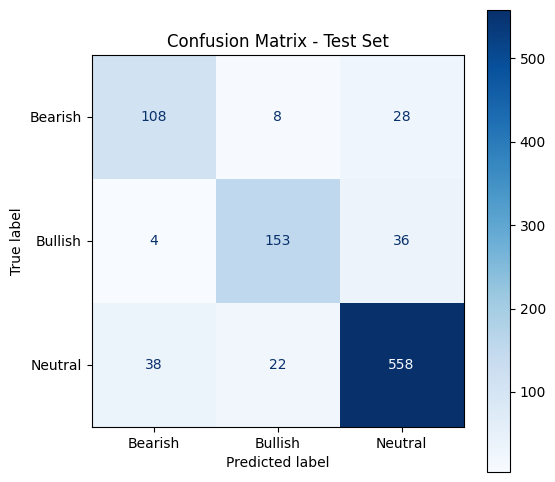

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(test_y_true, test_y_pred)

class_names = ["Bearish", "Bullish", "Neutral"]

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax, values_format='d')

plt.title("Confusion Matrix - Test Set")
plt.show()

The confusion matrix reveals that the BART model performs best at identifying Neutral and Bullish tweets, correctly classifying approximately 90% of Neutral and 78% of Bullish samples. However, the model shows some difficulty distinguishing Bearish tweets, with a notable portion being misclassified as Neutral. This confusion might stem from the linguistic similarities between Neutral and Bearish expressions, especially in financial contexts where subtle phrasing can blur the sentiment. Additionally, if the training data had fewer Bearish examples, the model may not have learned enough distinctive patterns for that class.

In [33]:
# Identify misclassified samples 
misclassified = df_eval[test_y_true != test_y_pred]

# Show 5 misclassified examples per true class
for label_id in sorted(test_y_true.unique()):
    print(f"\nMisclassified examples for true class '{label_map[label_id]}':\n")
    
    subset = misclassified[misclassified["true_label"] == label_id]
    sample = subset.sample(n=min(5, len(subset)), random_state=42)
    
    for _, row in sample.iterrows():
        print(f"- Text: {row['text_no_lemma_stem_with_stopwords']}")
        print(f"  True: {label_map[row['true_label']]}, Predicted: {label_map[row['pred_label']]}\n")


Misclassified examples for true class 'Bearish':

- Text: opec deal is much weaker than it look
  True: Bearish, Predicted: Neutral

- Text: fed policymak work to limit damag as pandem put you s economi on paus url url
  True: Bearish, Predicted: Neutral

- Text: la jolla pharmaceut to reassess continu develop of ljpc base on clinic result
  True: Bearish, Predicted: Neutral

- Text: ticker western digit may have troubl push stock price higher subscrib to seek alpha for more … url
  True: Bearish, Predicted: Bullish

- Text: introduc lannett compani nyse lci the stock that tank
  True: Bearish, Predicted: Neutral


Misclassified examples for true class 'Bullish':

- Text: whi intesa sanpaolo s p a s bit isp high p e ratio is not necessarili a bad thing
  True: Bullish, Predicted: Neutral

- Text: octob architectur bill index final sign of strength read more and get updat on ani stock … url
  True: Bullish, Predicted: Neutral

- Text: ticker move good today just play the movement but d

## 5 - Making predictions

In [ ]:
df_test = df_test.rename(columns={"text": "text_no_lemma_stem_with_stopwords"})

hf_test_dataset = Dataset.from_pandas(df_test)

# Tokenize the test dataset
hf_test_dataset = hf_test_dataset.map(
    lambda examples: tokenizer(
        examples["text_no_lemma_stem_with_stopwords"],
        padding="max_length",
        truncation=True,
        max_length=64
    ),
    batched=True
)

# Prepare for model input
hf_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

preds = final_trainer.predict(hf_test_dataset)
logits = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
test_predictions = np.argmax(logits, axis=1)

# Export predictions to CSV
df_submission = pd.DataFrame({
    "id": df_test["id"],  
    "label": test_predictions
})
df_submission.to_csv("pred_bart.csv", index=False)

print("Test predictions saved to pred_bart.csv")

Map: 100%|██████████| 2388/2388 [00:01<00:00, 2275.86 examples/s]


Test predictions saved to pred_bart.csv
